In [50]:
import pandas as pd
import numpy as np
import yfinance as yf
from statsmodels.tsa.stattools import coint
import ta
import matplotlib.pyplot as plt

In [19]:
prices_data = yf.download(['UBER','LYFT'], start='2024-01-01')['Adj Close']

[*********************100%%**********************]  2 of 2 completed


In [20]:
stock_1 = prices_data['UBER']
stock_2 = prices_data['LYFT']

In [30]:
# If non-stationary, stationarize by differencing
stock_1_diff = prices_data['UBER'].diff().dropna()  # First difference
stock_2_diff = prices_data['LYFT'].diff().dropna()  # First difference



In [31]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Assuming you used first differences (or log differences) for stationarity
stationary_data = np.column_stack([stock_1_diff, stock_2_diff])

# Perform Johansen test
johansen_result = coint_johansen(stationary_data, det_order=0, k_ar_diff=1)

# Print Johansen test results
print("Test Statistics: ", johansen_result.lr1)  # Test statistics
print("Critical Values: ", johansen_result.cvt)  # Critical values


Test Statistics:  [178.32523547  77.81345039]
Critical Values:  [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]


In [48]:
class PairTradingStrategy:
    def __init__(self, merged_data: pd.DataFrame, z_score_threshold: float, window1: int, window2: int,look_back:int,rsi_up:float,rsi_down:float):
        self.merged_data = merged_data
        self.z_score_threshold = z_score_threshold
        self.window1 = window1
        self.window2 = window2
        self.look_back=look_back
        self.rsi_up=rsi_up
        self.rsi_down=rsi_down
        self.pnl_data = []

    def execute_strategy(self) -> float:

        btc = self.merged_data['UBER'].astype(float)
        eth = self.merged_data['LYFT'].astype(float)
        ratios = btc / eth
        ma1 = ratios.rolling(window=self.window1).mean()
        ma2 = ratios.rolling(window=self.window2).mean()
        std = ratios.rolling(window=self.window1).std()
        zscore = (ratios - ma2) / std
        rsi = ta.momentum.RSIIndicator(ratios, window=self.window2).rsi()
        money = 0
        count_btc = count_eth = 0
        position = 0
        transaction_cost = 0.0005  # 0.05%
        cost = 0
        ewma_std = ratios.ewm(span=self.window2).std()
        MtM=0
        position_i=0
        for i in range(len(ratios)):
            dynamic_threshold = (self.z_score_threshold + (ewma_std[i]))
            if zscore[i] < dynamic_threshold and zscore[i-self.look_back:i].max() > dynamic_threshold and position == 0 and rsi[i]>self.rsi_up:
                cost = (btc[i] + (eth[i] * ratios[i])) * transaction_cost
                if (count_btc) >= 0 and (count_eth) <= 0:
                    money += btc[i] - eth[i] * ratios[i]-cost
                    count_btc -= 1
                    count_eth += ratios[i]
                    position = -1
                    position_i=i
                    MtM=0
            elif zscore[i] > -dynamic_threshold+0.2 and zscore[i-self.look_back:i].min() < -dynamic_threshold  and position == 0  and rsi[i]<self.rsi_down:
                cost = (btc[i] + (eth[i] * ratios[i])) * transaction_cost
                if (count_btc) <= 0 and (count_eth) <= 0:
                    money += btc[i] - eth[i] * ratios[i]-cost
                    count_btc += 1
                    count_eth -= ratios[i]
                    position = 1
                    position_i=i
                    MtM=0

            elif (zscore[i]) < dynamic_threshold*0.5 and zscore[i-self.look_back:i].max() > dynamic_threshold*0.5 and position == 1:
                cost = (btc[i] + (eth[i] * ratios[i])) * transaction_cost
                money += btc[i] * count_btc + eth[i] * count_eth-cost
                count_btc = 0
                count_eth = 0
                position = 0
                MtM = 0
            elif (zscore[i]) > -dynamic_threshold*0.5 and (zscore[i])+0.2 < dynamic_threshold*0.5 and zscore[i-self.look_back:i].min() < -dynamic_threshold*0.5 and position == -1:
                cost = (btc[i] + (eth[i] * ratios[i])) * transaction_cost
                money += btc[i] * count_btc + eth[i] * count_eth-cost
                count_btc = 0
                count_eth = 0
                position = 0
                MtM = 0
            else:
                if position==1:
                    MtM = (btc[i]*1 - eth[i] * ratios[position_i])
                elif position==-1:
                    MtM = (-btc[i]*1 + eth[i] * ratios[position_i])
                else:
                    MtM=0
                

            self.pnl_data.append(
                [ratios.index[i], money,MtM, count_btc, count_eth,ma1.iloc[i],ma2.iloc[i],ratios.iloc[i], self.merged_data['UBER'].iloc[i], self.merged_data['LYFT'].iloc[i], position,
                 zscore.iloc[i],dynamic_threshold, rsi.iloc[i]]
            )

        return money
    def visualize_strategy(self):
        PnL_df = pd.DataFrame(self.pnl_data,
                              columns=['Date', 'PnL', 'MtM', '#BTC', '#ETH','MA1','MA2','Ratio', 'Price BTC', 'Price ETH', 'Position',
                                       'z_score','Dynamic_Zscore', 'rsi'])
        # Identify trade signals for plotting
        PnL_df['TradeType'] = np.where((PnL_df['Position'] == 1) & (PnL_df['Position'].shift(1) == 0), 'Go Long',
                                       np.where((PnL_df['Position'] == -1) & (PnL_df['Position'].shift(1) == 0),
                                                'Go Short',
                                                np.where(
                                                    (PnL_df['Position'] == 0) & (abs(PnL_df['Position'].shift(1)) == 1),
                                                    'Exit Position', 'No Action')))
        PnL_df['Date']=pd.to_datetime(PnL_df['Date'])
        PnL_df=PnL_df.set_index("Date")

        fig, axes = plt.subplots(4, 1, figsize=(10, 15), sharex=True)

        axes[0].plot(PnL_df['Ratio'], label='Ratio')
        axes[0].axhline(PnL_df['Ratio'].mean(), color='black')
        axes[0].plot(PnL_df['MA1'], label="EMA1")
        axes[0].plot(PnL_df['MA2'], label="EMA2")
        axes[0].legend(loc='upper left')
        axes[0].set_title('BTC and ETH Pair Ratio')

        # Plot 2: Z-Score
        axes[1].plot(PnL_df['z_score'], label='Z-Score', color='orange')
        axes[1].plot(PnL_df['Dynamic_Zscore'], color='r', linestyle='--', label='Upper Threshold')
        axes[1].plot(-PnL_df['Dynamic_Zscore'], linestyle='--', label='Lower Threshold')
        axes[1].plot(PnL_df['Dynamic_Zscore']*0.5, color='g',  linestyle='--', label='Mid Threshold')
        axes[1].plot(-PnL_df['Dynamic_Zscore']*0.5, color='g',  linestyle='--', label='Mid Threshold')
        axes[1].plot(PnL_df['Position'], color='grey',  linestyle='--', label='Position')

        # axes[1].axhline(y=1, color='r', linestyle='--', label='Upper Threshold')
        # axes[1].axhline(y=-1, color='r', linestyle='--', label='Lower Threshold')
        # axes[1].axhline(y=0.5, color='g', linestyle='--', label='Mid Threshold')
        # axes[1].axhline(y=-0.5, color='g', linestyle='--', label='Mid Threshold')
        axes[1].legend(loc='upper left')
        axes[1].set_title('Z-Score')

        Long = PnL_df[PnL_df['TradeType'] == 'Go Long']
        Short = PnL_df[PnL_df['TradeType'] == 'Go Short']
        Exit = PnL_df[PnL_df['TradeType'] == 'Exit Position']

        axes[2].plot(Long['PnL'], marker='^', color='green', linestyle='', markersize=10,
                     label='Long Signal')
        axes[2].plot(Short['PnL'], marker='^', color='orange', linestyle='', markersize=10,
                     label='Short Signal')
        axes[2].plot(Exit['PnL'], marker='v', color='red', linestyle='', markersize=10,
                     label='Exit Signal')

        axes[2].plot(PnL_df['PnL'], label='PnL', color='purple')
        axes[2].plot(PnL_df['MtM'], label='MtM', color='red')
        axes[2].legend(loc='upper left')
        axes[2].set_title('PnL of strategy')

        axes[3].plot(PnL_df['rsi'], label='RSI', color='orange')
        axes[3].axhline(y=50, color='r', linestyle='--')
        axes[3].legend(loc='upper left')
        axes[3].set_title('RSI')
        # Display the plots
        # plt.tight_layout()
        # plt.savefig('BTC_ETH.png')
        plt.show()
        PnL_df.to_excel("log2.xlsx")

C:\Users\adnan\AppData\Local\Temp\ipykernel_4364\3910498383.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dynamic_threshold = (self.z_score_threshold + (ewma_std[i]))
C:\Users\adnan\AppData\Local\Temp\ipykernel_4364\3910498383.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if zscore[i] < dynamic_threshold and zscore[i-self.look_back:i].max() > dynamic_threshold and position == 0 and rsi[i]>self.rsi_up:
C:\Users\adnan\AppData\Local\Temp\ipykernel_4364\3910498383.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as la

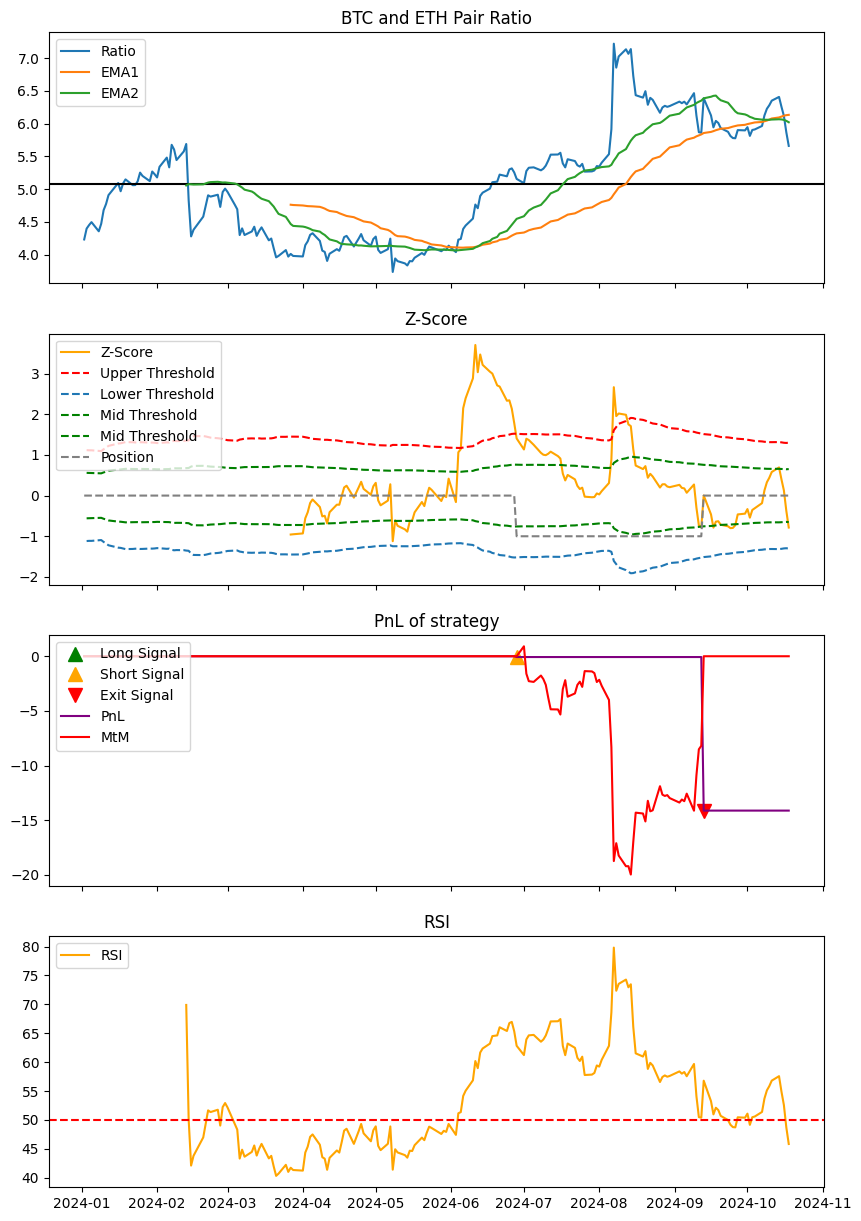

In [56]:

if __name__ == "__main__":
    strategy = PairTradingStrategy(prices_data, 1, 60, 30,5,40,60)
    strategy.execute_strategy()
    strategy.visualize_strategy()